In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import ast

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
import plotly.express as px

In [ ]:
overview = pd.read_csv('data_for_comparison/overview.csv').rename(columns={'name': 'dataset'})

In [ ]:
metrics = pd.DataFrame({'metrics': ['mse', 'mae', 'r2', 'acc', 'auc', 'f1'], 'ascending_metrics': [0, 0, 1, 1, 1, 1]})

In [ ]:
fo_map = {
    'ridge': 'ridge', 'logit': 'logit',
    'knn': 'knn', 'knnreg': 'knn',
    'dt': 'dt', 'dtreg': 'dt',
    'rf': 'rf', 'rfr': 'rf',
    'lgbm': 'lgbm', 'lgbmreg': 'lgbm'
}

In [ ]:
data_safe = pd.read_csv('long_comparison_.csv', sep='#')
data_safe['params'] = ('{' + data_safe['pipeline'].str.split('{', expand=True)[1].str.split('}', expand=True)[0] + '}').fillna('{}').apply(lambda x: ast.literal_eval(x))
data_safe = pd.concat([data_safe, data_safe['params'].apply(pd.Series)], axis=1).merge(overview).merge(metrics)
data_safe.drop(columns=['pipeline', 'params'], inplace=True)
data_safe['fitted_operation'] = data_safe['fitted_operation'].map(fo_map)

data_safe['min_samples_leaf'].loc[data_safe['fitted_operation'] == 'lgbm'] /= data_safe[data_safe['fitted_operation'] == 'lgbm']['rows'] * 0.8

data_safe['is_default'] = np.where((data_safe['fitted_operation'] == 'ridge') & (data_safe['alpha'].isna()), 1, 0)
data_safe['is_default'] = np.where((data_safe['fitted_operation'] == 'logit') & (data_safe['C'].isna()), 1, data_safe['is_default'])
data_safe['is_default'] = np.where((data_safe['fitted_operation'] == 'knn') & (data_safe['weights'].isna()), 1, data_safe['is_default'])
data_safe['is_default'] = np.where((data_safe['fitted_operation'] == 'dt') & (data_safe['min_samples_leaf'].isna()), 1, data_safe['is_default'])
data_safe['is_default'] = np.where((data_safe['fitted_operation'] == 'rf') & (data_safe['min_samples_leaf'].isna()), 1, data_safe['is_default'])
data_safe['is_default'] = np.where((data_safe['fitted_operation'] == 'lgbm') & (data_safe['learning_rate'] == 0.03), 1, data_safe['is_default'])

data_safe

In [ ]:
data_safe[(data_safe['dataset'] == 'brazilian-houses') & (data_safe['fitted_operation'] == 'dt') & (data_safe['metrics'] == 'mse')]

In [ ]:
is_default = data_safe[data_safe['approach'] != 'default'].groupby(['dataset', 'fitted_operation', 'metrics']).agg({'is_default': 'mean'}).reset_index().merge(overview)
is_default['metrics'] = is_default['fitted_operation'] + '_' + is_default['metrics']
fig = px.scatter(is_default, x='rows', y='is_default', color='metrics', text='dataset')
fig.show()

In [ ]:
data_safe[(data_safe['is_default'] == 1) & (data_safe['fitted_operation'] == 'rf') & (data_safe['approach'] != 'default')].groupby('metrics').count()

In [ ]:
data = data_safe[data_safe['is_default'] == 0]
data[['max_score_train', 'max_score_test']] = data.groupby(['dataset', 'metrics', 'fitted_operation']).transform(max)[['score_train', 'score_test']]
data[['min_score_train', 'min_score_test']] = data.groupby(['dataset', 'metrics', 'fitted_operation']).transform(min)[['score_train', 'score_test']]
data_best_train = data[np.where(np.isin(data['metrics'], ['mse', 'mae']),
                                data['score_train'] == data['min_score_train'], 
                                data['score_train'] == data['max_score_train'])]
data_best_test = data[np.where(np.isin(data['metrics'], ['mse', 'mae']),
                               data['score_test'] == data['min_score_test'], 
                               data['score_test'] == data['max_score_test'])]

In [ ]:
params = {
    'ridge': {
        'alpha': ('loguniform', [1e-9, 1e4])
    },
    'logit': {
        'C': ('loguniform', [1e-9, 1e4])
    },
    'knn': {
        'n_neighbors': ('randint', [1, 100]),
        'metric': ('choice', [['euclidean', 'manhattan', 'chebyshev', 'cosine']]),
        'weights': ('choice', [['uniform', 'distance']])
    },
    'dt': {
        'max_depth': ('randint', [2, 15]),
        'min_samples_leaf': ('uniform', [1e-4, 0.5])
    },
    'rf': {
        'n_estimators': ('randint', [10, 1000]),
        'max_features': ('uniform', [0.2, 1]),
        'bootstrap': ('choice', [[True, False]]),
        'max_depth': ('randint', [2, 15]),
        'min_samples_leaf': ('uniform', [1e-4, 0.5])
    },
    'lgbm': {
        'n_estimators': ('randint', [10, 1000]),
        'learning_rate': ('loguniform', [1e-4, 1e1]),
        'max_depth': ('randint', [2, 15]),
        'min_samples_leaf': ('uniform', [1e-4, 0.5]),
        'colsample_bytree': ('uniform', [0.2, 1]),
        'subsample': ('uniform', [0.2, 1]),
        'max_bin': ('randint', [3, 511]),
        'lambda_l1': ('loguniform', [1e-5, 1e2]),
        'lambda_l2': ('loguniform', [1e-5, 1e2])
    }
}

In [169]:
data_safe[(data_safe['dataset'] == 'brazilian-houses') & (data_safe['fitted_operation'] == 'dt') & (data_safe['metrics'] == 'mse')]

,dataset,metrics,fitted_operation,approach,experiment_number,score_train,score_test,time_spent,alpha,n_jobs,...,weights,C,rows,num_features,cat_features,num_classes,task,source,ascending_metrics,is_default
548,brazilian-houses,mse,dt,default,0,0.000000e+00,109165.769986,0.852361,NaN,NaN,...,NaN,NaN,10692,9,3,-1,regression,https://www.openml.org/d/42688,0,1
555,brazilian-houses,mse,dt,random,1,9.893093e+06,231107.108929,161.946350,NaN,NaN,...,NaN,NaN,10692,9,3,-1,regression,https://www.openml.org/d/42688,0,1
561,brazilian-houses,mse,dt,tpe,0,9.861649e+06,220971.877045,246.608281,NaN,NaN,...,NaN,NaN,10692,9,3,-1,regression,https://www.openml.org/d/42688,0,1
564,brazilian-houses,mse,dt,tpe,1,9.892979e+06,258908.743338,126.385125,NaN,NaN,...,NaN,NaN,10692,9,3,-1,regression,https://www.openml.org/d/42688,0,1
565,brazilian-houses,mse,dt,default,1,0.000000e+00,109165.769986,0.717097,NaN,NaN,...,NaN,NaN,10692,9,3,-1,regression,https://www.openml.org/d/42688,0,1
574,brazilian-houses,mse,dt,random,0,9.893093e+06,231107.108929,150.215249,NaN,NaN,...,NaN,NaN,10692,9,3,-1,regression,https://www.openml.org/d/42688,0,1


In [167]:
is_default = data_safe[data_safe['approach'] != 'default'].groupby(['dataset', 'fitted_operation', 'metrics']).agg({'is_default': 'mean'}).reset_index().merge(overview)
is_default['metrics'] = is_default['fitted_operation'] + '_' + is_default['metrics']
fig = px.scatter(is_default, x='rows', y='is_default', color='metrics', text='dataset')
fig.show()

In [150]:
data_safe[(data_safe['is_default'] == 1) & (data_safe['fitted_operation'] == 'rf') & (data_safe['approach'] != 'default')].groupby('metrics').count()

,dataset,fitted_operation,approach,experiment_number,score_train,score_test,time_spent,alpha,n_jobs,num_leaves,...,C,name,rows,num_features,cat_features,num_classes,task,source,ascending_metrics,is_default
metrics,,,,,,,,,,,,,,,,,,,,,
auc,8,8,8,8,8,8,8,0,8,0,...,0,8,8,8,8,8,8,8,8,8
f1,21,21,21,21,21,21,21,0,21,0,...,0,21,21,21,21,21,21,21,21,21
mae,20,20,20,20,20,20,20,0,20,0,...,0,20,20,20,20,20,20,20,20,20
mse,14,14,14,14,14,14,14,0,14,0,...,0,14,14,14,14,14,14,14,14,14
r2,14,14,14,14,14,14,14,0,14,0,...,0,14,14,14,14,14,14,14,14,14


In [127]:
data = data_safe[data_safe['is_default'] == 0]
data[['max_score_train', 'max_score_test']] = data.groupby(['dataset', 'metrics', 'fitted_operation']).transform(max)[['score_train', 'score_test']]
data[['min_score_train', 'min_score_test']] = data.groupby(['dataset', 'metrics', 'fitted_operation']).transform(min)[['score_train', 'score_test']]
data_best_train = data[np.where(np.isin(data['metrics'], ['mse', 'mae']),
                                data['score_train'] == data['min_score_train'], 
                                data['score_train'] == data['max_score_train'])]
data_best_test = data[np.where(np.isin(data['metrics'], ['mse', 'mae']),
                               data['score_test'] == data['min_score_test'], 
                               data['score_test'] == data['max_score_test'])]

In [128]:
params = {
    'ridge': {
        'alpha': ('loguniform', [1e-9, 1e4])
    },
    'logit': {
        'C': ('loguniform', [1e-9, 1e4])
    },
    'knn': {
        'n_neighbors': ('randint', [1, 100]),
        'metric': ('choice', [['euclidean', 'manhattan', 'chebyshev', 'cosine']]),
        'weights': ('choice', [['uniform', 'distance']])
    },
    'dt': {
        'max_depth': ('randint', [2, 15]),
        'min_samples_leaf': ('uniform', [1e-4, 0.5])
    },
    'rf': {
        'n_estimators': ('randint', [10, 1000]),
        'max_features': ('uniform', [0.2, 1]),
        'bootstrap': ('choice', [[True, False]]),
        'max_depth': ('randint', [2, 15]),
        'min_samples_leaf': ('uniform', [1e-4, 0.5])
    },
    'lgbm': {
        'n_estimators': ('randint', [10, 1000]),
        'learning_rate': ('loguniform', [1e-4, 1e1]),
        'max_depth': ('randint', [2, 15]),
        'min_samples_leaf': ('uniform', [1e-4, 0.5]),
        'colsample_bytree': ('uniform', [0.2, 1]),
        'subsample': ('uniform', [0.2, 1]),
        'max_bin': ('randint', [3, 511]),
        'lambda_l1': ('loguniform', [1e-5, 1e2]),
        'lambda_l2': ('loguniform', [1e-5, 1e2])
    }
}

In [129]:
def plot_distr(data_):
    for fo in params:
        for param in params[fo]:
            info = params[fo][param]
            if param not in data.columns:
                continue
            data_tmp = data_[data_['fitted_operation'] == fo][[param]].dropna()
            if data_tmp.shape[0] == 0:
                continue

            print(fo, param)
            if info[0] == 'choice':
                sns.barplot(data=data_tmp.reset_index().groupby(param, as_index=False).count().rename(columns={'index': 'cnt'}), x=param, y='cnt')
                plt.show()
            else:
                sns.histplot(data_tmp, log_scale=info[0] == 'loguniform')
                plt.xlim(*info[1])
                plt.show()

ridge alpha


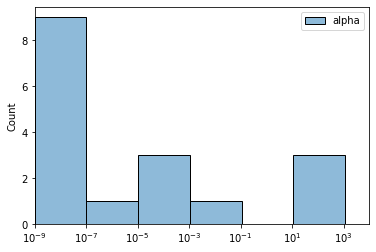

logit C


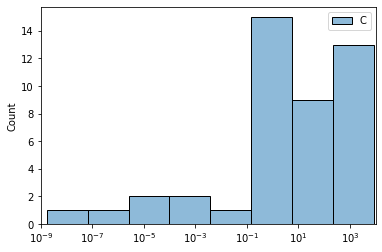

knn n_neighbors


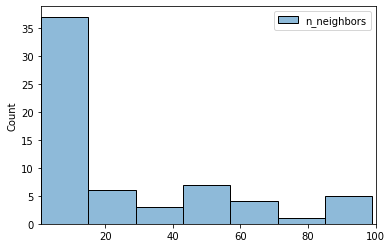

knn metric


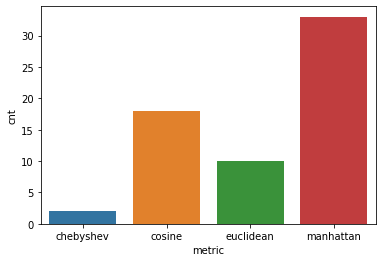

knn weights


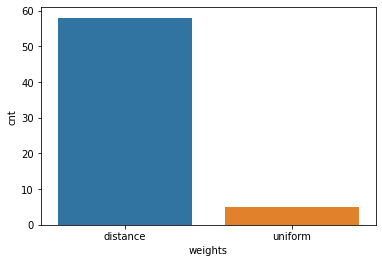

dt max_depth


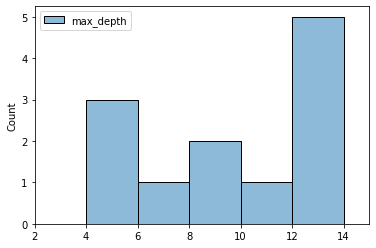

dt min_samples_leaf


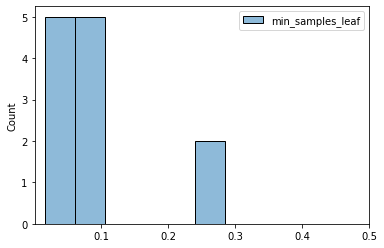

rf n_estimators


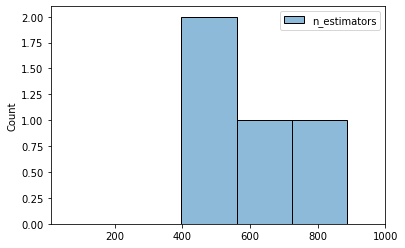

rf max_features


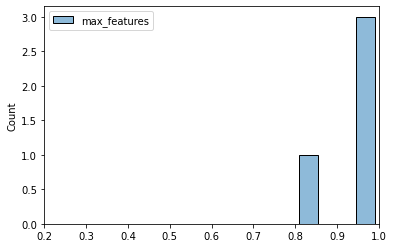

rf bootstrap


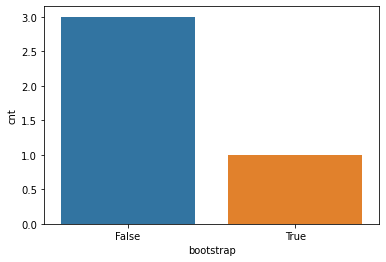

rf max_depth


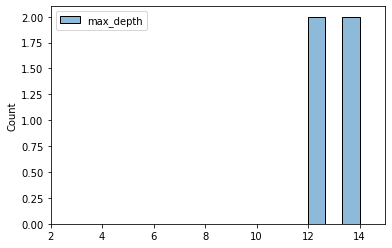

rf min_samples_leaf


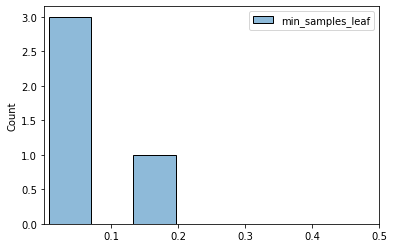

lgbm n_estimators


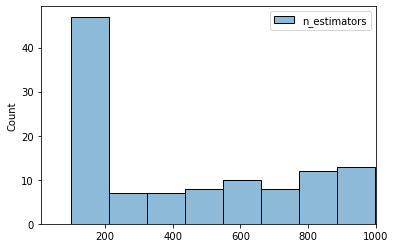

lgbm learning_rate


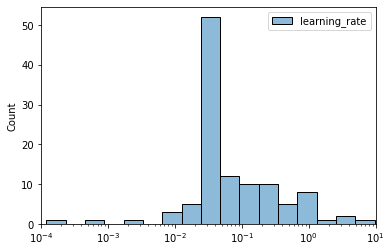

lgbm max_depth


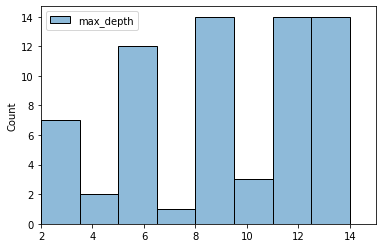

lgbm min_samples_leaf


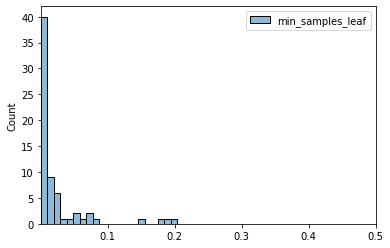

lgbm colsample_bytree


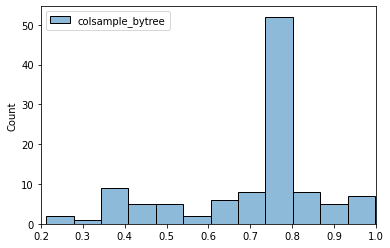

lgbm subsample


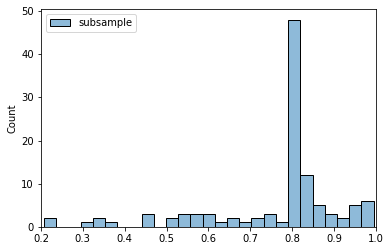

lgbm max_bin


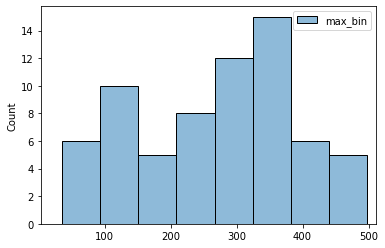

lgbm lambda_l1


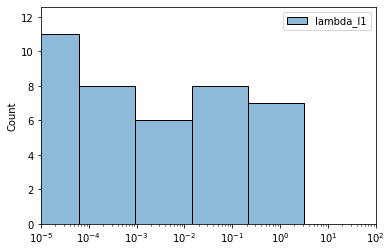

lgbm lambda_l2


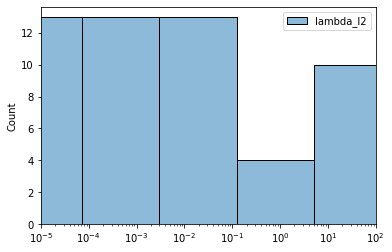

In [130]:
plot_distr(data_best_train)

ridge alpha


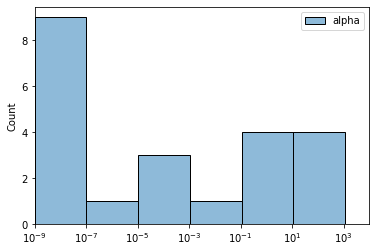

logit C


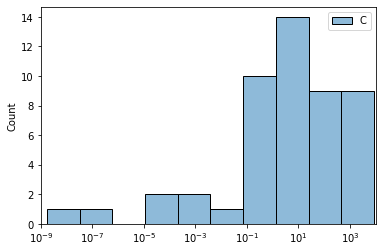

knn n_neighbors


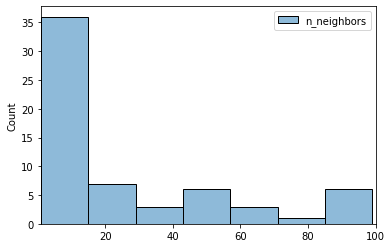

knn metric


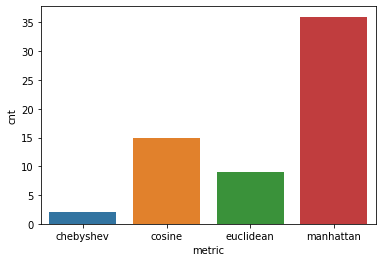

knn weights


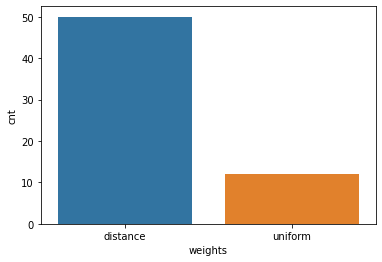

dt max_depth


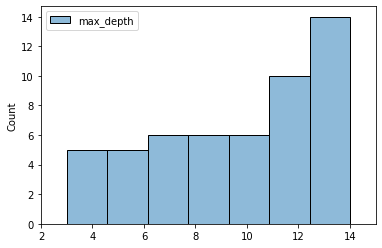

dt min_samples_leaf


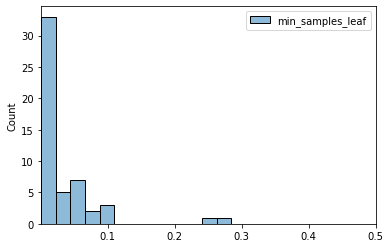

rf n_estimators


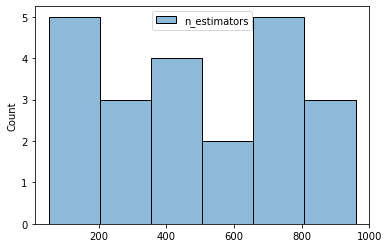

rf max_features


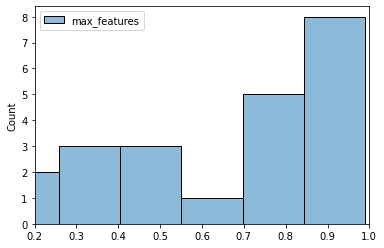

rf bootstrap


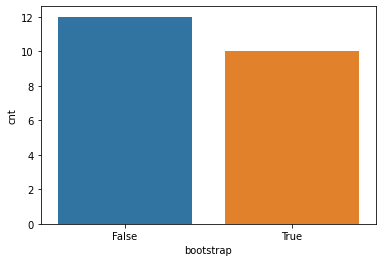

rf max_depth


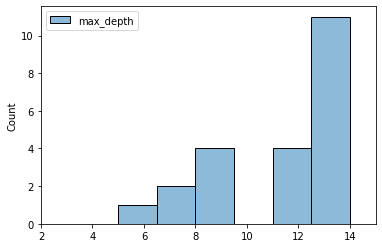

rf min_samples_leaf


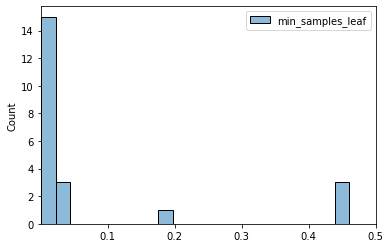

lgbm n_estimators


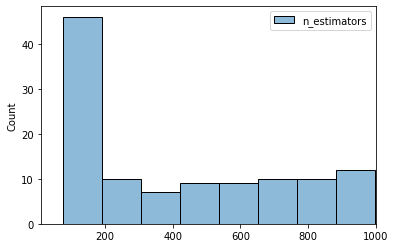

lgbm learning_rate


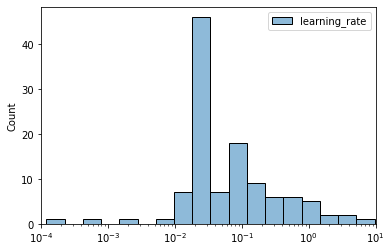

lgbm max_depth


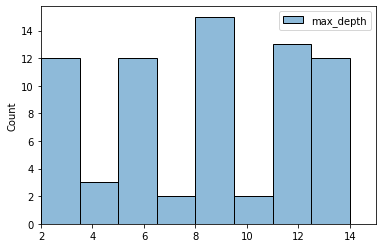

lgbm min_samples_leaf


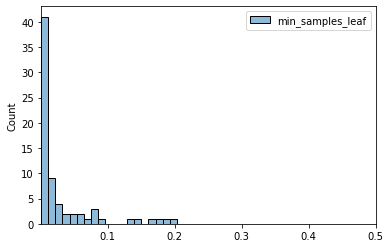

lgbm colsample_bytree


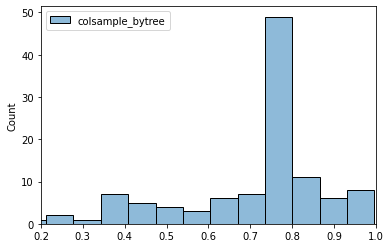

lgbm subsample


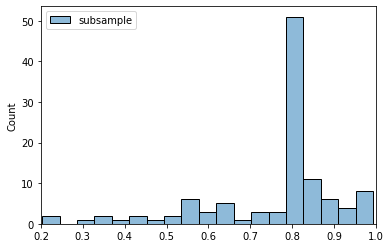

lgbm max_bin


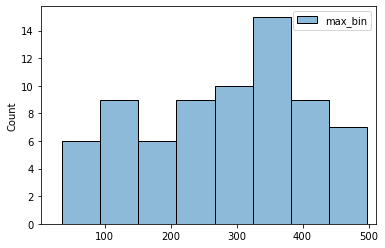

lgbm lambda_l1


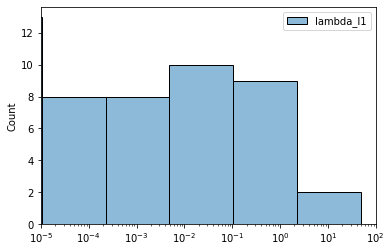

lgbm lambda_l2


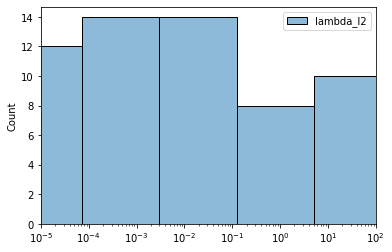

In [131]:
plot_distr(data_best_test)

In [82]:
need_columns = ['dataset', 'metrics', 'fitted_operation', 'score_train', 'score_test', 'time_spent']
opt_comparison = data_safe[data_safe['approach'] == 'random'][need_columns].merge(data_safe[data_safe['approach'] == 'tpe'][need_columns],
                                                                                  on=['dataset', 'metrics', 'fitted_operation'],
                                                                                  suffixes=('_random', '_tpe')).merge(data_safe[data_safe['approach'] == 'default'][need_columns],
                                                                                                                      on=['dataset', 'metrics', 'fitted_operation'])

In [45]:
opt_comparison['train_diff_random'] = np.where(np.isin(opt_comparison['metrics'], ['mse', 'mae']),
                                               (opt_comparison['score_train'] - opt_comparison['score_train_random']) / np.maximum(opt_comparison['score_train_random'], opt_comparison['score_train']),
                                               (opt_comparison['score_train_random'] - opt_comparison['score_train']) / np.maximum(opt_comparison['score_train_random'], opt_comparison['score_train']))
opt_comparison['train_diff_tpe'] = np.where(np.isin(opt_comparison['metrics'], ['mse', 'mae']),
                                            (opt_comparison['score_train'] - opt_comparison['score_train_tpe']) / np.maximum(opt_comparison['score_train_tpe'], opt_comparison['score_train']),
                                            (opt_comparison['score_train_tpe'] - opt_comparison['score_train']) / np.maximum(opt_comparison['score_train_tpe'], opt_comparison['score_train']))
opt_comparison['test_diff_random'] = np.where(np.isin(opt_comparison['metrics'], ['mse', 'mae']),
                                              (opt_comparison['score_test'] - opt_comparison['score_test_random']) / np.maximum(opt_comparison['score_test_random'], opt_comparison['score_test']),
                                              (opt_comparison['score_test_random'] - opt_comparison['score_test']) / np.maximum(opt_comparison['score_test_random'], opt_comparison['score_test']))
opt_comparison['test_diff_tpe'] = np.where(np.isin(opt_comparison['metrics'], ['mse', 'mae']),
                                           (opt_comparison['score_test'] - opt_comparison['score_test_tpe']) / np.maximum(opt_comparison['score_test_tpe'], opt_comparison['score_test']),
                                           (opt_comparison['score_test_tpe'] - opt_comparison['score_test']) / np.maximum(opt_comparison['score_test_tpe'], opt_comparison['score_test']))

In [51]:
opt_comparison.sort_values('test_diff_tpe').dropna()

,dataset,metrics,fitted_operation,score_train_random,score_test_random,time_spent_random,score_train_tpe,score_test_tpe,time_spent_tpe,score_train,score_test,time_spent,train_diff_random,train_diff_tpe,test_diff_random,test_diff_tpe
1064,house-sales,r2,knnreg,0.011259,-0.009579,1515.798512,0.011168,-0.009538,1895.491813,0.201583,-0.197613,9.329742,-0.944145,-0.944596,-19.630321,-19.718391
1410,brazilian-houses,r2,lgbmreg,0.907400,-1.841148,317.460871,0.694033,-8.749512,243.009204,0.220372,0.659656,1.101465,0.757139,0.682476,-3.791074,-14.263753
1405,brazilian-houses,r2,lgbmreg,0.627471,-3.597057,342.388761,0.694033,-8.749512,243.009204,0.220372,0.659656,1.478629,0.648793,0.682476,-6.452930,-14.263753
1406,brazilian-houses,r2,lgbmreg,0.627471,-3.597057,342.388761,0.694033,-8.749512,243.009204,0.220372,0.659656,1.101465,0.648793,0.682476,-6.452930,-14.263753
1409,brazilian-houses,r2,lgbmreg,0.907400,-1.841148,317.460871,0.694033,-8.749512,243.009204,0.220372,0.659656,1.478629,0.757139,0.682476,-3.791074,-14.263753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,house-sales,r2,rfr,0.021567,0.016104,1905.437665,0.022881,0.015741,1954.885063,0.855257,-0.025740,30.701229,-0.974783,-0.973247,2.598322,2.635168
152,house-sales,r2,dtreg,0.016762,0.013466,880.836985,0.016762,0.013466,407.304170,0.999848,-1.028149,3.940724,-0.983235,-0.983235,77.349029,77.349029
154,house-sales,r2,dtreg,0.017302,0.010978,1821.572227,0.016762,0.013466,407.304170,0.999848,-1.028149,3.940724,-0.982695,-0.983235,94.654662,77.349029
153,house-sales,r2,dtreg,0.016762,0.013466,880.836985,0.016762,0.013466,407.304170,0.999848,-1.048788,4.138284,-0.983235,-0.983235,78.881673,78.881673


In [52]:
opt_comparison = opt_comparison[(opt_comparison['test_diff_tpe'] < 1) & (opt_comparison['test_diff_tpe'] > -1)]
opt_comparison = opt_comparison[(opt_comparison['train_diff_tpe'] < 1) & (opt_comparison['train_diff_tpe'] > -1)]
opt_comparison = opt_comparison[(opt_comparison['test_diff_random'] < 1) & (opt_comparison['test_diff_random'] > -1)]
opt_comparison = opt_comparison[(opt_comparison['test_diff_random'] < 1) & (opt_comparison['test_diff_random'] > -1)]

-0.03095963466486615


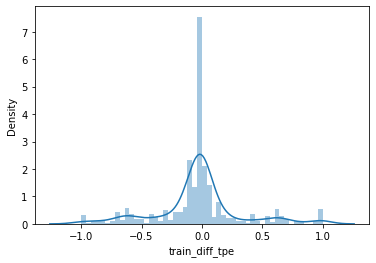

In [60]:
diff_ = opt_comparison['train_diff_tpe'] #- opt_comparison['train_diff_random']
print(np.mean(diff_))
sns.distplot(diff_.dropna())
plt.show()

0.007126585325579643


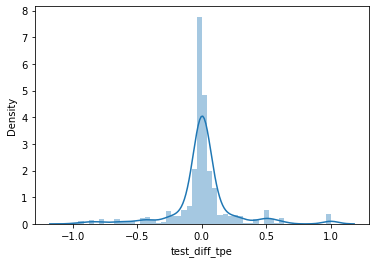

In [61]:
diff_ = opt_comparison['test_diff_tpe'] #- opt_comparison['test_diff_random']
print(np.mean(diff_))
sns.distplot(diff_.dropna())
plt.show()

In [79]:
data.groupby(['max_bin']).count()['dataset']

max_bin
15.0     2
17.0     1
21.0     1
35.0     1
42.0     1
        ..
497.0    1
498.0    1
501.0    1
505.0    2
508.0    1
Name: dataset, Length: 170, dtype: int64